In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import time
import math
import bghelperfunctions as bg
from bghelperfunctions import TimeBandTargets
import scipy.ndimage.measurements as im_meas
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]

## Data import and munging

In [174]:
# sim data
dts = np.array([(datetime.datetime.now()-datetime.timedelta(minutes=30*x)) for x in range(4*30*24*2)]);

bg_max = 15 * 18.0;
bg_min = 2.5 * 18.0;
calibrated_readings_flat = np.array([bg_max/2 + bg_min/2 for dt in dts]);
calibrated_readings_daily_hypo = abs(np.array([2.5*18.0 if dt.hour==(datetime.datetime.now() - datetime.timedelta(hours=1)).hour 
                                  else (bg_max/2 + bg_min/2) for dt in dts]) + np.random.normal(loc=0, scale=9.0, size=len(dts)))
calibrated_readings_sine = abs(bg_min + (bg_max - bg_min) * abs(np.sin(np.array([2* math.pi *dt.hour/48 for dt in dts]))) + np.random.normal(loc=0, scale=9.0, size=len(dts)));

df = pd.DataFrame();
df['datetime'] = dts;
df['datetime'] = pd.to_datetime(df['datetime'])
df['datetime'] = df['datetime']
df['calibrated_reading'] = calibrated_readings_sine;
df.set_index(df['datetime'], inplace=True);

# # real data
# df = pd.read_csv('C:\\Users\\Doug\\Dropbox\\Apps\\Glimp\\GlicemiaMisurazioni.csv.gz', 
#                 compression='gzip', 
#                 header=None, 
#                 sep=';',
#                 encoding='utf-16-le', 
#                 usecols=[1,4,5], 
#                 names=['datetime', 'uncalibrated_reading', 'calibrated_reading'])

df['datetime'] = pd.to_datetime(df['datetime'], format='%d/%m/%Y %H.%M.%S').dt.round('1s');
df['time'] = df['datetime'].dt.time
df['date'] = df['datetime'].dt.date
df['BG, mmoll-1'] = (df['calibrated_reading']/18.0).round(1)
df.set_index(df['datetime'], inplace=True)


## Today's BGs

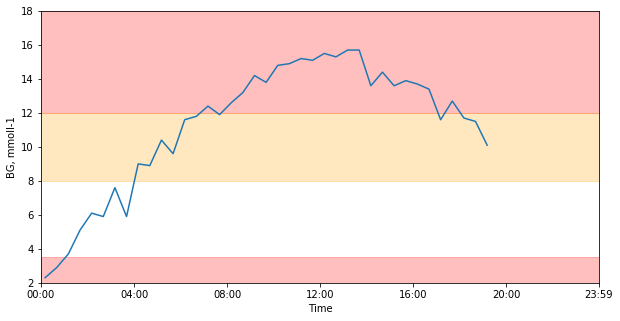

In [175]:
fig, ax = plt.subplots(1,1,figsize=[10,5])
bg.plot_daily_BG(df, datetime.date.today(), ax)


## This week's BGs

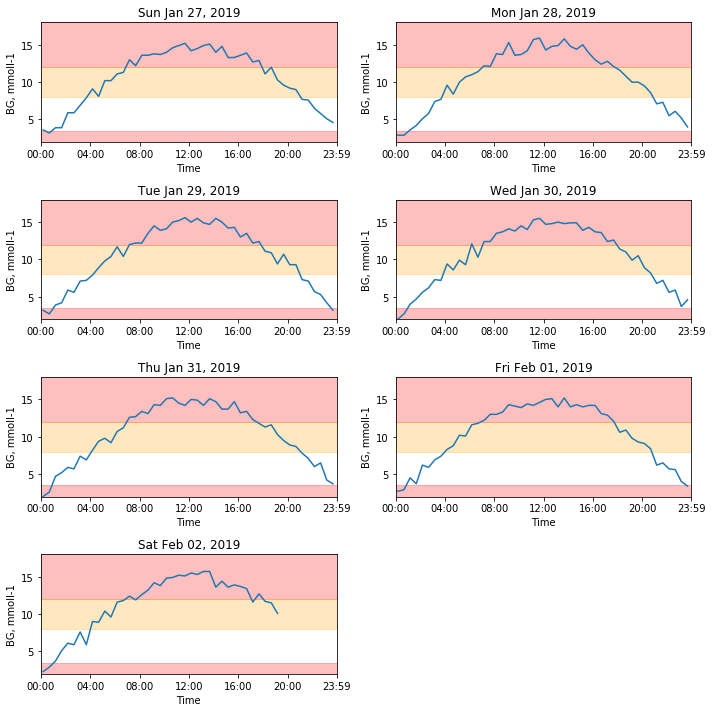

In [176]:
plt.rcParams['figure.figsize'] = [10, 10]
sunday = bg.lastWday(datetime.date.today() - datetime.timedelta(days=0), 6)
weekdays = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']

fig2, ax2 = plt.subplots(4,2, figsize=[10,10])
for didx in range(7):
    date = sunday + datetime.timedelta(days=didx)
    axidx = (int(math.floor(didx/2)), didx % 2)
    if date <= datetime.date.today():
        bg.plot_daily_BG(df, date, ax2[axidx])
        ax2[axidx].set_title(date.strftime("%a %b %d, %Y"))
    else:
        ax2[axidx].set_visible(False)
ax2[-1,1].set_visible(False)
plt.tight_layout()


## Monthly summary

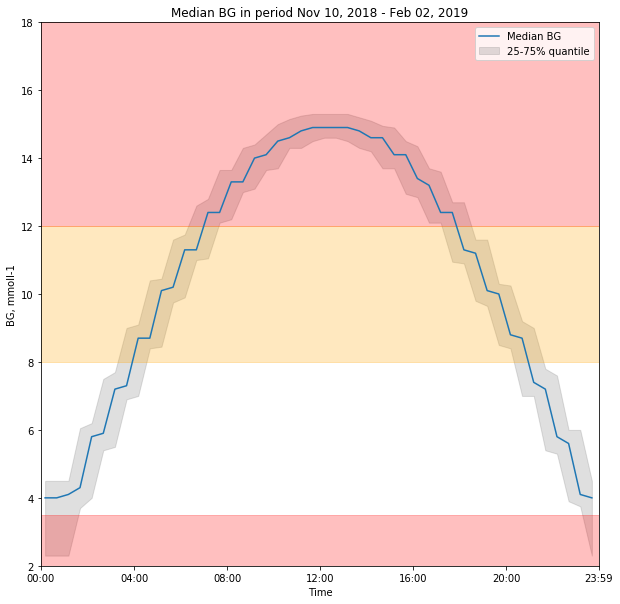

In [177]:
enddate = datetime.date.today()
startdate = datetime.date.today() - datetime.timedelta(days=28*3)
ax = bg.plot_long_term_BG(df, startdate, enddate)

In [178]:
def percentageTimeInTarget(df, startdate, enddate, time_band_target_list):
    """plot % time below/in/above targets, using time-banded targets object"""
    sample_df = df.loc[(df['date'] >= startdate) & (df['date'] <= enddate)]
    
    for tidx, time_band_target in enumerate(time_band_target_list):
        tb_times = time_band_target.time_start_end
        tb_targets = time_band_target.target_bg
        band_start_t = datetime.time(hour=int(math.floor(tb_times[0])), minute=int(tb_times[0]-math.floor(tb_times[0])))
        band_end_t = datetime.time(hour=int(math.floor(tb_times[1])), minute=int(tb_times[1]-math.floor(tb_times[1])))
        sub_sample_df = sample_df.loc[(sample_df['time'] >= band_start_t) & (sample_df['time'] <= band_end_t)]['BG, mmoll-1']
    
        t = sub_sample_df.index
        r = pd.date_range(t.min(), t.max(), freq='30S')
        interp_df = sub_sample_df.reindex(t.union(r)).interpolate('index')
        
        time_band_target_list[tidx].percentage_below_target = np.round(100.0 * (interp_df < tb_targets[0]).sum() / interp_df.count(),1)
        time_band_target_list[tidx].percentage_in_target = np.round(100.0 * ((interp_df >= tb_targets[0]) & (interp_df <= tb_targets[1])).sum() / interp_df.count(),1)
        time_band_target_list[tidx].percentage_above_target = np.round(100.0 * (interp_df > tb_targets[1]).sum() / interp_df.count(),1)
        
    
    # handle plotting
    fig, ax = plt.subplots(1,1)
    idx = len(time_band_target_list) - np.arange(len(time_band_target_list));
    xindices = np.arange(len(time_band_target_list))
    bar_w = 0.35
    rects = []
    # note that repeat looping here isn't ideal, but such a small penalty it's not worth fixing
    above_lims = [tbt.percentage_above_target for tbt in time_band_target_list]
    in_lims = [tbt.percentage_in_target for tbt in time_band_target_list]
    below_lims = [tbt.percentage_below_target for tbt in time_band_target_list]
    
    rects.append(ax.bar(xindices, 
                        below_lims, 
                        bar_w, 
                        color='orange', 
                        label='Below target'))
    rects.append(ax.bar(xindices, 
                        in_lims, 
                        bar_w, 
                        color='g', 
                        bottom=below_lims, 
                        label='Within target'))
    rects.append(ax.bar(xindices, 
                        above_lims, 
                        bar_w, 
                        color='r', 
                        bottom=[sum(x) for x in zip(below_lims, in_lims)], 
                        label='Above target'))
    ax.set_xticks(xindices)
    ax.set_xticklabels([tbt.time_band_name for tbt in time_band_target_list])
    ax.set_ylabel("Percentage time in each range")
    ax.set_xlabel("Periods of interest")
    ax.legend()
    ax.set_title(startdate.strftime("Time spent within target ranges in period %b %d, %Y - " + enddate.strftime("%b %d, %Y")))
    
    # handle labeling
    labels = []
    for cidx, container in enumerate(rects):
        for ridx, rect in enumerate(container):
            tbt = time_band_target_list[ridx];
            pc_lbls = (tbt.percentage_below_target, tbt.percentage_in_target, tbt.percentage_above_target);

            if (rect.get_height() > 3):
                yloc = rect.get_y() + rect.get_height()/2.0
                xloc = rect.get_x() + rect.get_width()/2.0

                pc_str = str.format("{0} %", pc_lbls[cidx])
                label = ax.text(xloc, yloc, pc_str, horizontalalignment='center',
                             verticalalignment='center', color='w', weight='bold',
                             clip_on=True)
                labels.append(label)
    return time_band_target_list;


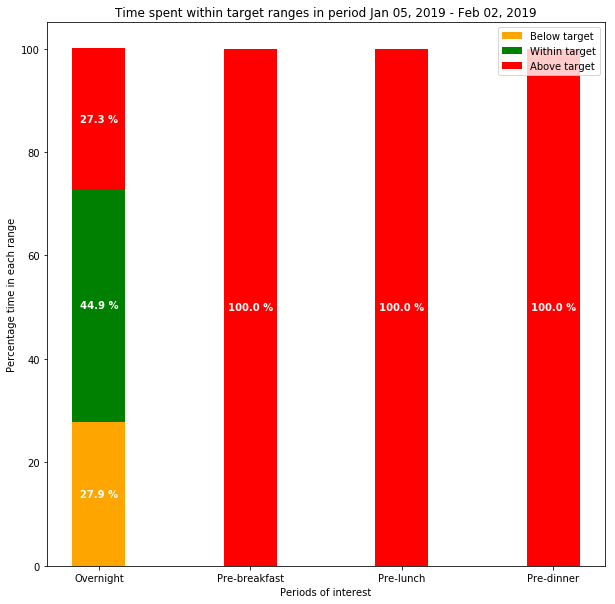

In [179]:
time_band_targetses = [];
time_band_targetses.append(TimeBandTargets());
time_band_targetses.append(TimeBandTargets(time_band_name='Pre-breakfast',
                                           time_start_end=(7,8),
                                           target_bg=(4.0, 8.0)))
time_band_targetses.append(TimeBandTargets(time_band_name='Pre-lunch',
                                           time_start_end=(10.5,12),
                                           target_bg=(3.5, 8.0)))
time_band_targetses.append(TimeBandTargets(time_band_name='Pre-dinner',
                                           time_start_end=(16,18),
                                           target_bg=(3.5, 8.0)))

enddate = datetime.date.today()
startdate = datetime.date.today() - datetime.timedelta(days=28*1)
output = bg.percentageTimeInTarget(df, startdate, enddate, time_band_targetses);

In [196]:
def plot_hypos(df, startdate, enddate=datetime.date.today(), hypo_max_bg=3.5):
    """show colourmap and provide basis for extracting stats on separate hypoglycaemic episodes"""
    sample_df = df.loc[(df['date'] >= startdate) & (df['date'] <= enddate)];
    
    # ensure even sampling
    t = sample_df.index
    r = pd.date_range(t.min(), t.max(), freq='30S')
    interp_df = sample_df.reindex(t.union(r)).interpolate('index')
#     interp_df = sample_df
    
    # binarise hypos and label each distinct hypo event
    mask = (interp_df['BG, mmoll-1'] < hypo_max_bg).values
    lbl, nfeat = im_meas.label((mask).astype(int))
    o = im_meas.find_objects(lbl)
    hypo_starts_t = np.asarray([interp_df.index[x[0].start].time() for x in o])
    hypo_starts_dt = [interp_df.index[x[0].start] for x in o]
    #durations = [minus_time(interp_df.index[x[0].stop].time(), interp_df.index[x[0].start].time()) for x in o]
    #print([d.total_seconds() for d in durations])
    
    days = np.unique(interp_df.index.date)
    if enddate==datetime.date.today():
        days = days[1:-1]
    hypo_arr = np.zeros((len(days), (2*60*24)))
    
    for didx, day in enumerate(days):
#         daily_BG = np.tile(interp_df.loc[interp_df.index.date == day]['BG, mmoll-1'], 60);
        daily_BG = interp_df.loc[interp_df.index.date == day]['BG, mmoll-1'];
        hypo_arr[didx, :] = daily_BG

    hypo_arr = np.ma.masked_where(hypo_arr>hypo_max_bg, hypo_arr)
    
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    cbdum = ax.imshow(hypo_arr, aspect='auto', cmap='Reds_r', clim=(2.0,3.5), interpolation=None)
    fig.subplots_adjust(top=0.9, right=0.9, hspace=0.1);
    cax = fig.add_axes([0.95, ax.get_position().y0, 0.03, ax.get_position().y1 - ax.get_position().y0])
    fig.colorbar(cbdum, cax=cax);

    t = [x * 4 * 2 * 60 for x in range(6)]
    d = [x * 4 for x in range(int(len(days)/4))]
    d.append(hypo_arr.shape[0]-1)
    ax.set_xticks(t)
    ax.set_yticks(d)
    tlbl = [datetime.time(hour= int(math.floor(tx / (2 * 60))), minute=0) for tx in t]
    dlbl = [x.strftime("%Y-%b-%d") for x in days[d]]
    ax.set_xticklabels(tlbl)
    ax.set_xlabel("Time of day")
    ax.set_yticklabels(dlbl)
    ax.set_ylabel("Date")
    ax.set_title(startdate.strftime("Hypoglycaemic episodes in period %b %d, %Y - " + enddate.strftime("%b %d, %Y")))
    cax.set_ylabel("BG, mmoll-1")
    plt.show()
    
    return ax

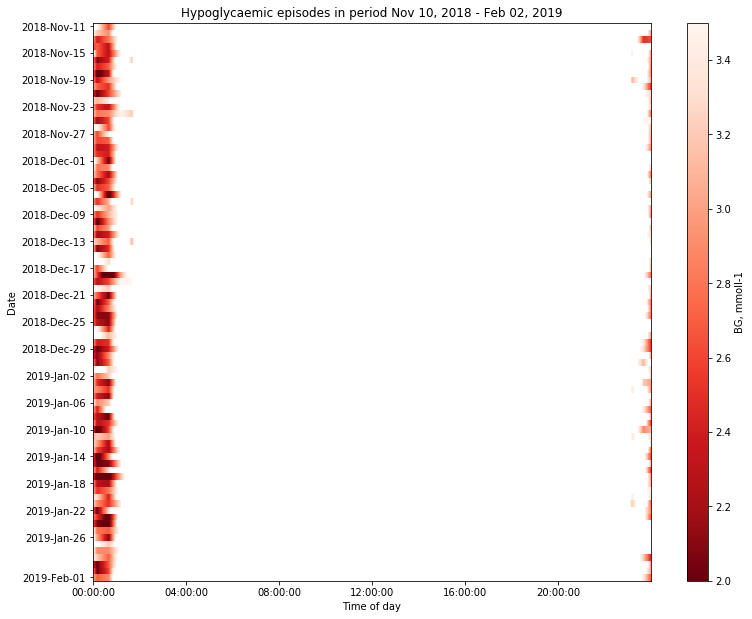

In [197]:
enddate = datetime.date.today()
startdate = datetime.date.today() - datetime.timedelta(days=28*3)
%prun plot_hypos(df, startdate, enddate)
